In [62]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

SO="BPO"

/mnt/e/ML/cafa-5-protein-function-prediction


## Reading fasta, obo and tsv files

In [63]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [64]:
print("There are {} sequences in the dataset.".format(len(sequences)))

There are 142246 sequences in the dataset.


In [65]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)

# Number of nodes
print(len(graph))

# Number of edges
print(graph.number_of_edges())

# Check if the ontology is a DAG
print(networkx.is_directed_acyclic_graph(graph))


43248
84805
True


In [66]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')
uniqueTerms = df["term"].unique()
termsArr = list(df["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
termToken = [uniqueTermsDict[el] for el in termsArr]
df["termToken"] = termToken
df.head(10)

,EntryID,term,aspect,termToken
0,A0A009IHW8,GO:0008152,BPO,0
1,A0A009IHW8,GO:0034655,BPO,1
2,A0A009IHW8,GO:0072523,BPO,2
3,A0A009IHW8,GO:0044270,BPO,3
4,A0A009IHW8,GO:0006753,BPO,4
5,A0A009IHW8,GO:1901292,BPO,5
6,A0A009IHW8,GO:0044237,BPO,6
7,A0A009IHW8,GO:1901360,BPO,7
8,A0A009IHW8,GO:0008150,BPO,8
9,A0A009IHW8,GO:1901564,BPO,9


Test for the first entry:

In [67]:
%timeit df.loc[df['EntryID'] == "A0A009IHW8"]

163 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
df.set_index("EntryID", inplace=True)

In [69]:
%timeit df.loc["A0A009IHW8"]

43.7 ms ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
termHist= df["term"].value_counts()
termHist

GO:0005575    92912
GO:0008150    92210
GO:0110165    91286
GO:0003674    78637
GO:0005622    70785
              ...  
GO:0031772        1
GO:0042324        1
GO:0031771        1
GO:0051041        1
GO:0102628        1
Name: term, Length: 31466, dtype: int64

In [71]:
uniqueSeq=df.index.unique()
uniqueSeq[1000:1300]

Index(['A0A0G2JTI9', 'A0A0G2JTL4', 'A0A0G2JTP1', 'A0A0G2JTU1', 'A0A0G2JTU9',
       'A0A0G2JTY3', 'A0A0G2JTY4', 'A0A0G2JTZ2', 'A0A0G2JU12', 'A0A0G2JU33',
       ...
       'A0A0G2KTP6', 'A0A0G2KUJ0', 'A0A0G2KUL6', 'A0A0G2KUW7', 'A0A0G2KXI9',
       'A0A0G2KXP0', 'A0A0G2KXQ3', 'A0A0G2KYH9', 'A0A0G2KYI1', 'A0A0G2KZA4'],
      dtype='object', name='EntryID', length=300)

In [72]:
df.loc["A0A0G2KUJ0"]

,term,aspect,termToken
EntryID,,,
A0A0G2KUJ0,GO:0070121,BPO,4183
A0A0G2KUJ0,GO:0051234,BPO,561
A0A0G2KUJ0,GO:0032402,BPO,4184
A0A0G2KUJ0,GO:0032401,BPO,4185
A0A0G2KUJ0,GO:0032502,BPO,69
A0A0G2KUJ0,GO:0051649,BPO,822
A0A0G2KUJ0,GO:0051641,BPO,341
A0A0G2KUJ0,GO:0009987,BPO,26
A0A0G2KUJ0,GO:0048856,BPO,44


In [73]:
np.unique(df["aspect"].to_numpy())

array(['BPO', 'CCO', 'MFO'], dtype=object)

In [74]:
uniqueBPOTerms = np.unique(df.loc[df["aspect"]=="BPO"]["term"].to_numpy())
print(uniqueBPOTerms.size)
uniqueMFOTerms = np.unique(df.loc[df["aspect"]=="MFO"]["term"].to_numpy())
print(uniqueMFOTerms.size)
uniqueCCOTerms = np.unique(df.loc[df["aspect"]=="CCO"]["term"].to_numpy())
print(uniqueCCOTerms.size)

21285
7224
2957


In [75]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)
dfIa.loc["GO:0031772"]

1    0.0
Name: GO:0031772, dtype: float64

In [76]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]

dfGo.set_index("term", inplace=True)

## GO analysis

In [77]:
item_counts = df["term"].value_counts()
print(item_counts[0:30].to_numpy())

[92912 92210 91286 78637 70785 61293 60883 58315 57380 55452 53193 52218
 47987 41457 39256 33888 31098 30448 29274 28932 28680 28274 27366 25768
 25324 25273 24419 21784 21579 20467]


In [78]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}
print(id_to_name['GO:0005575'] )
print(id_to_name['GO:0008150'] )
print(id_to_name['GO:0110165'] )

cellular_component
biological_process
cellular anatomical entity


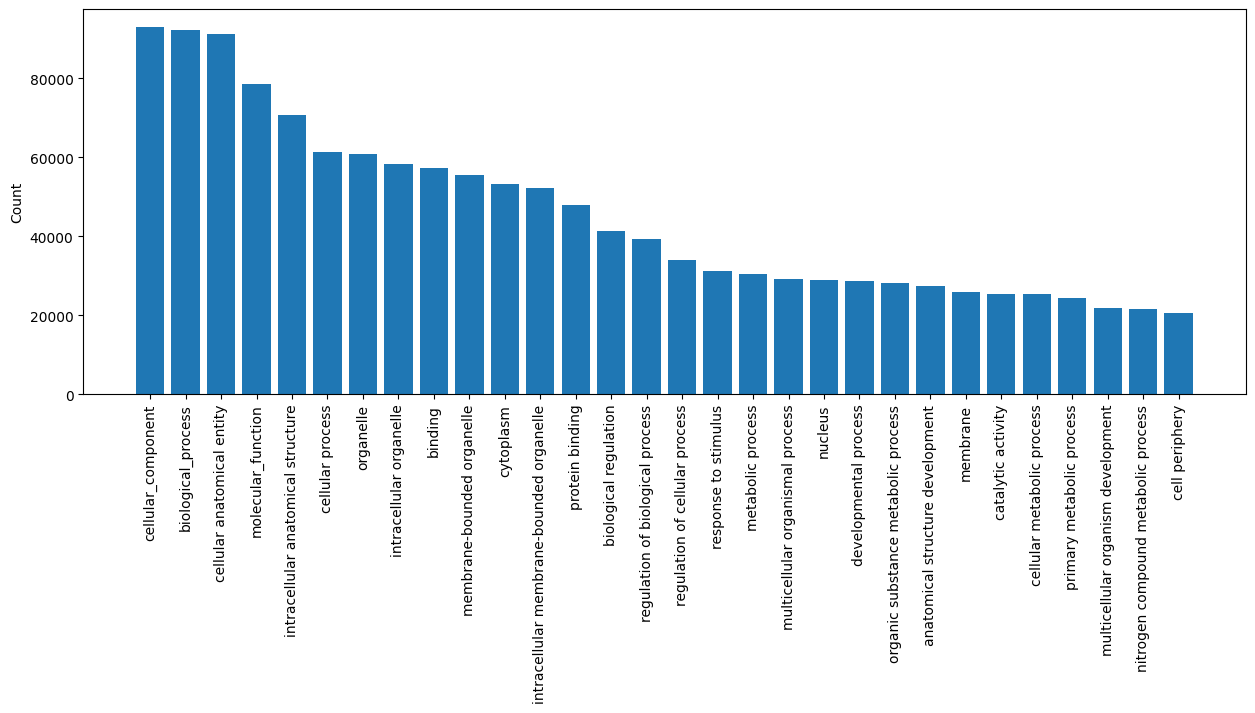

In [79]:
_ = plt.figure(figsize=(15,5))
_ = plt.bar([id_to_name[el] for el in list(item_counts[0:30].index)], item_counts[0:30].to_numpy())
_ = plt.xticks(rotation=90)
_ = plt.ylabel("Count")

In [80]:
print(id_to_name['GO:0042324'] )
print(networkx.ancestors(graph, 'GO:0042324'))
print(networkx.descendants(graph, 'GO:0042324'))

paths = networkx.all_simple_paths(
    graph,
    source='GO:0034668',
    target=name_to_id['cellular_component']
)

for path in paths:
    print('•', ' ⟶ '.join(id_to_name[node] for node in path))

orexin receptor binding
{'GO:0031772', 'GO:0031771'}
{'GO:0005515', 'GO:0003674', 'GO:0071855', 'GO:0005102', 'GO:0005488', 'GO:0001664'}
• integrin alpha4-beta1 complex ⟶ integrin complex ⟶ protein complex involved in cell adhesion ⟶ protein-containing complex ⟶ cellular_component
• integrin alpha4-beta1 complex ⟶ integrin complex ⟶ plasma membrane signaling receptor complex ⟶ receptor complex ⟶ protein-containing complex ⟶ cellular_component
• integrin alpha4-beta1 complex ⟶ integrin complex ⟶ plasma membrane signaling receptor complex ⟶ plasma membrane protein complex ⟶ membrane protein complex ⟶ protein-containing complex ⟶ cellular_component
• integrin alpha4-beta1 complex ⟶ integrin complex ⟶ plasma membrane signaling receptor complex ⟶ plasma membrane protein complex ⟶ membrane protein complex ⟶ membrane ⟶ cellular anatomical entity ⟶ cellular_component
• integrin alpha4-beta1 complex ⟶ integrin complex ⟶ plasma membrane signaling receptor complex ⟶ plasma membrane protein compl

In [81]:
allGOs= df.loc["A0A009IHW8"]["term"].to_numpy()
print([[id_to_name[el],el] for el in allGOs])

[['metabolic process', 'GO:0008152'], ['nucleobase-containing compound catabolic process', 'GO:0034655'], ['purine-containing compound catabolic process', 'GO:0072523'], ['cellular nitrogen compound catabolic process', 'GO:0044270'], ['nucleoside phosphate metabolic process', 'GO:0006753'], ['nucleoside phosphate catabolic process', 'GO:1901292'], ['cellular metabolic process', 'GO:0044237'], ['organic cyclic compound metabolic process', 'GO:1901360'], ['biological_process', 'GO:0008150'], ['organonitrogen compound metabolic process', 'GO:1901564'], ['organonitrogen compound catabolic process', 'GO:1901565'], ['nucleotide metabolic process', 'GO:0009117'], ['nucleobase-containing compound metabolic process', 'GO:0006139'], ['small molecule metabolic process', 'GO:0044281'], ['nicotinamide nucleotide metabolic process', 'GO:0046496'], ['pyridine nucleotide metabolic process', 'GO:0019362'], ['heterocycle metabolic process', 'GO:0046483'], ['nucleobase-containing small molecule metabolic

### Find GOs without ancestors

In [82]:
sortedGOs = list(networkx.topological_sort(graph))
rootGOs = []
for g in sortedGOs:
    if len(networkx.ancestors(graph,g)) ==0:
        rootGOs.append(g)
    else:
        break
        
print(rootGOs)
print(len(rootGOs))

['GO:0000001', 'GO:0000006', 'GO:0000007', 'GO:0000010', 'GO:0000011', 'GO:0000015', 'GO:0000016', 'GO:0000017', 'GO:0000024', 'GO:0000025', 'GO:0000031', 'GO:0000032', 'GO:0000034', 'GO:0000035', 'GO:0000036', 'GO:0000048', 'GO:0000050', 'GO:0000053', 'GO:0000080', 'GO:0000084', 'GO:0000085', 'GO:0000088', 'GO:0000089', 'GO:0000091', 'GO:0000092', 'GO:0000093', 'GO:0000095', 'GO:0000100', 'GO:0000102', 'GO:0000107', 'GO:0000110', 'GO:0000111', 'GO:0000113', 'GO:0000121', 'GO:0000124', 'GO:0000131', 'GO:0000140', 'GO:0000142', 'GO:0000145', 'GO:0000148', 'GO:0000150', 'GO:0000155', 'GO:0000156', 'GO:0000159', 'GO:0000162', 'GO:0000170', 'GO:0000171', 'GO:0000172', 'GO:0000210', 'GO:0000213', 'GO:0000214', 'GO:0000215', 'GO:0000222', 'GO:0000223', 'GO:0000224', 'GO:0000225', 'GO:0000227', 'GO:0000234', 'GO:0000236', 'GO:0000237', 'GO:0000238', 'GO:0000239', 'GO:0000240', 'GO:0000241', 'GO:0000242', 'GO:0000243', 'GO:0000244', 'GO:0000246', 'GO:0000247', 'GO:0000248', 'GO:0000249', 'GO:0

In [83]:
print(networkx.ancestors(graph, sortedGOs[1000]))
print(id_to_name[sortedGOs[1000]])

set()
regulation of COPII vesicle coating


### How many of them are used in our dataset?

In [84]:
dataRootGOs = np.intersect1d(uniqueTerms,rootGOs)
print(len(dataRootGOs))

14247


### How many nodes are in each layer?

In [85]:
layerSizes={}
for layer, nodes in enumerate(networkx.topological_generations(graph)):
    layerSizes[layer] = len(nodes)

print(layerSizes)

{0: 23827, 1: 8405, 2: 4667, 3: 2512, 4: 1411, 5: 858, 6: 535, 7: 367, 8: 222, 9: 148, 10: 113, 11: 74, 12: 46, 13: 28, 14: 16, 15: 10, 16: 6, 17: 2, 18: 1}


<span style="color:lightblue">Cave: layer 0 is the most specific layer. Whereas layer 18 is Biological Process</span>

### If we only consider layers lower than m, would every sequence have at least one of these low-level GOs assigned?

In [86]:
relevantNodes=[]
for layer, nodes in enumerate(networkx.topological_generations(graph)):
    if layer<10:
        relevantNodes = relevantNodes + nodes

In [87]:
len(relevantNodes)

42952

In [88]:
reducedDf = df[df["term"].isin(relevantNodes)]

In [89]:
print("Count of unique sequences in reduced dataset:", np.unique(reducedDf.index).shape)
print("Count of unique sequences in full dataset:", np.unique(df.index).shape)

print(reducedDf.shape)
print(df.shape)

Count of unique sequences in reduced dataset: (139837,)
Count of unique sequences in full dataset: (142246,)
(2954070, 3)
(5363863, 3)


In [90]:
# setdiff=np.setdiff1d(np.unique(df.index), np.unique(reducedDf.index))
# setdiff.shape

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

In [91]:
from sklearn.preprocessing import MultiLabelBinarizer


dftest=df.loc["A0A009IHW8"]
indices = dftest["termToken"].to_numpy()

mlb = MultiLabelBinarizer()
mlb.fit([termToken])
print(indices)
print(mlb.transform([indices]))


[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42 24242 24243 24244 24245 24246
 24247]
[[1 1 1 ... 0 0 0]]


For testing purposes, we only want to consider the 100 most common GOs

In [92]:
topGOs= item_counts[0:10]
topGOs=topGOs.index.to_list()

mlb = MultiLabelBinarizer()
mlb.fit([topGOs])
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42 24242 24243 24244 24245 24246
 24247]
[[0 0 0 0 0 0 0 0 0 0]]
10


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 24242, 24243, 24244, 24245, 24246, 24247, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 5, 6, 7, 8, 9] will be ignored
  warnings.warn(


In [93]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()



notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


## Amino acids encoding

In [94]:
aminos_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']

- A: Alanine
- C: Cysteine
- D: Aspartic acid
- E: Glutamic acid
- F: Phenylalanine
- G: Glycine
- H: Histidine
- I: Isoleucine
- K: Lysine
- L: Leucine
- M: Methionine
- N: Asparagine
- O: Pyrrolysine
- P: Proline
- Q: Glutamine
- R: Arginine
- S: Serine
- T: Threonine
- U: Selenocystein
- V: Valine
- W: Tryptophan
- Y: Tyrosine
- X: unknown

In [95]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

In [96]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq, MutableSeq

X =ProteinAnalysis(sequences[2])
# X =ProteinAnalysis(Seq("EEEEEEEEEEXFATGGGGHHHHHLLMLMLQR"))

# Can't handle 'X' as amino acid
print("mol weight ", X.molecular_weight())
print("instab ", X.instability_index())
print("flex ", X.flexibility())
print("flex len", len(X.flexibility()))
print("gravy ", X.gravy())

# Can handle 'X' as amino acid
print("aromaticity ", X.aromaticity())
print("aa perc ", X.get_amino_acids_percent())
print("aa perc len", len(X.get_amino_acids_percent()))
print("protScale ", X.protein_scale(aa_dict, 100))
print("protScale len ", len(X.protein_scale(aa_dict, 100)))
print("isoelectric point ", X.isoelectric_point())
print("charge at ph7 ", X.charge_at_pH(7))
print("charge at ph3 ", X.charge_at_pH(3))
print("charge at ph10 ", X.charge_at_pH(10))
print("molar extinction coeff ", X.molar_extinction_coefficient())
print("sec structure coeff ", X.secondary_structure_fraction())


mol weight  27552.045899999976
instab  52.88104651162789
flex  [1.0239404761904762, 1.032452380952381, 1.0361190476190476, 1.0313809523809523, 1.0408214285714283, 1.034654761904762, 1.0261190476190476, 1.0253333333333334, 0.9973452380952379, 1.0314404761904763, 1.010297619047619, 0.9791190476190476, 1.0226071428571426, 1.0018214285714286, 0.9738809523809524, 1.0147380952380953, 0.958047619047619, 0.9959285714285716, 1.0159880952380953, 0.9984999999999999, 1.0103333333333335, 1.0112142857142856, 0.990202380952381, 1.0413809523809523, 1.0104285714285712, 1.0142023809523808, 0.9997261904761905, 0.9974761904761904, 1.017940476190476, 1.0186547619047617, 1.0061666666666667, 1.019547619047619, 1.0021190476190476, 1.0265714285714285, 0.978547619047619, 1.0260000000000002, 0.9779285714285716, 1.015, 1.0052738095238094, 0.985154761904762, 1.0337499999999997, 1.015785714285714, 1.028702380952381, 1.024452380952381, 1.029988095238095, 1.0218095238095237, 1.0335952380952382, 1.022797619047619, 1.0

## Build Dataset

In [97]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


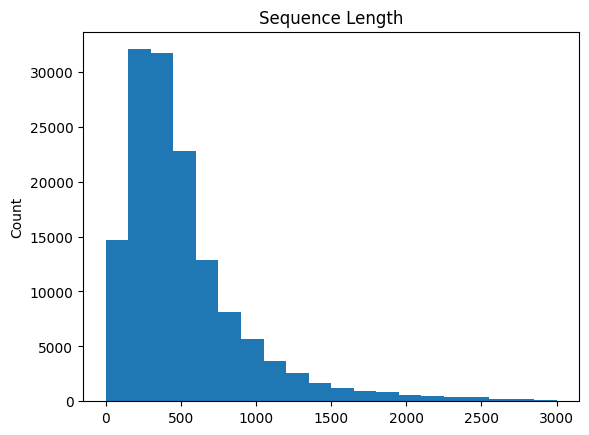

In [98]:
_=plt.hist(seqLengths, 20,(0,3000))
_=plt.title("Sequence Length")
_=plt.ylabel("Count")

In [99]:
import warnings

TRAIN_VAL_SPLIT = 0.7

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)

#reduce data for now
sequencesShuffle = sequencesShuffle[0:2000]
idsShuffle = idsShuffle[0:2000]

#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator(padding=True):
    for i,seq in enumerate(trainSeq):
        entryId = trainIds[i]
        labelData = df.loc[entryId]
        
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()

        with warnings.catch_warnings():
            #supress the warnings for unknown classes
            warnings.simplefilter("ignore")
            y = mlb.transform([indices])
        
        arr = np.array(seq)
        mappedArr = vectMapping(arr)
        if padding:
            padWidth = maxLen - arr.size
            mappedArr = np.pad(mappedArr, (0, padWidth))
        yield mappedArr,y[0]

def generatorVal(padding=True):
    for i,seq in enumerate(valSeq):
        entryId = valIds[i]
        labelData = df.loc[entryId]
        
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()

        with warnings.catch_warnings():
            #supress the warnings for unknown classes
            warnings.simplefilter("ignore")
            y = mlb.transform([indices])
        
        arr = np.array(seq)
        mappedArr = vectMapping(arr)
        if padding:
            padWidth = maxLen - arr.size
            mappedArr = np.pad(mappedArr, (0, padWidth))
        yield mappedArr,y[0]
        

1400


In [100]:
g = generator()
test = next(g)
print("The first sample sequence: {}".format(test[0]))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample sequence: [11 16  3 ...  0  0  0]
The first sample has 1 classes


## Basic classification

In [101]:
X=[]
y=[]
for i,el in enumerate(g):
    X.append(el[0])
    y.append(el[1])
    if i ==10:
        break

In [102]:

X= np.array(X)
y= np.array(y)
print(X.shape)
print(y.shape)

(11, 35375)
(11, 10)


In [103]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
# clf.fit(X, y)

# print(clf.score(X,y))
# print(clf.decision_path([X[0]]))
# print(clf.predict([X[0]]))

## Tensorflow Classification

In [104]:
import tensorflow as tf


dataset = tf.data.Dataset.from_generator(generator, output_signature=(
         tf.TensorSpec(shape=(maxLen,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))
print(list(dataset.take(1)))

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))

2023-08-21 12:05:31.385799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-21 12:05:31.408100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-21 12:05:31.408457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-21 12:05:31.410057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-21 12:05:31.410380: I tensorflow/compile

[(<tf.Tensor: shape=(35375,), dtype=int32, numpy=array([11, 16,  3, ...,  0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>)]


In [105]:
%load_ext tensorboard


In [106]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=100

def createModel():
    inputs = tf.keras.Input(shape=(maxLen,))
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name="embedding")(inputs)
    x=layers.GlobalAveragePooling1D()(x)
    x=layers.Reshape((EMBED_DIM,1))(x)
    x=layers.Conv1D(8, 7)(x)
    x=layers.Conv1D(8, 7)(x)
    x=layers.Conv1D(8, 7)(x)
    x=layers.Conv1D(16, 7)(x)
    x=layers.Conv1D(16, 7)(x)
    x=layers.Conv1D(16, 7, strides=2)(x)
    x=layers.Conv1D(16, 7, strides=2)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(16)(x)
    x=layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedConvModel")

# model = createModel()

# model.summary()


Model: "embedRnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35375)]           0         
                                                                 
 masking_1 (Masking)         (None, 35375)             0         
                                                                 
 embedding (Embedding)       (None, 35375, 200)        5000      
                                                                 
 lstm (LSTM)                 (None, 32)                29824     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)              

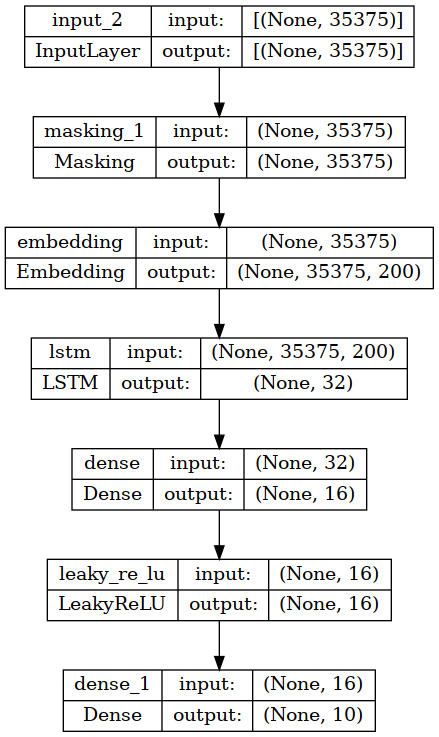

In [107]:

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=200

def createRnnModel():
    inputs = tf.keras.Input(shape=(maxLen,))
    x = tf.keras.layers.Masking(0)(inputs)
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(x)

    # x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    # x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    # x = layers.Bidirectional(layers.GRU(16))(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(16)(x)
    x = layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedRnnModel")

model = createRnnModel()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

/tmp/ipykernel_17484/2623022177.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,max(plt.ylim())])


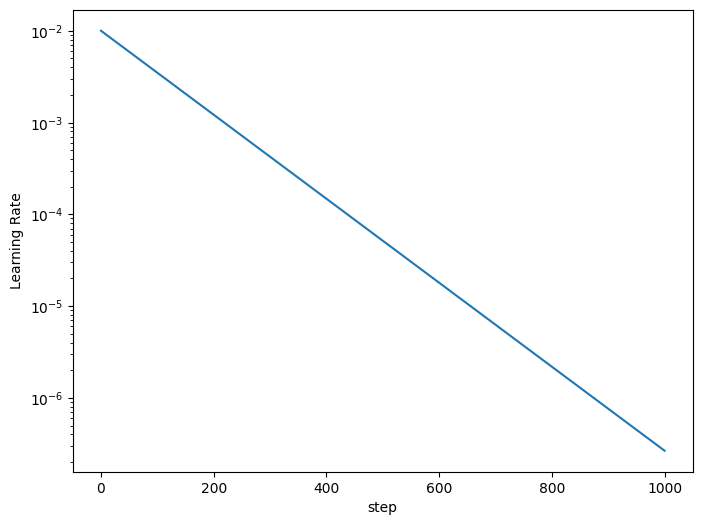

In [ ]:

#Learning rate schedule
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=False)
step = np.linspace(0,1000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.yscale("log")
plt.plot(step, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('step')
_ = plt.ylabel('Learning Rate')

In [ ]:
BATCH_SIZE=32
LOG_INTERVAL=5
epochs = 20
saveModel=False


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)

# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)
# print(batchedDataset.take(1))

batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"))
batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"))

# @tf.function()
def trainStep(x_batch_train, y_batch_train):
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        probs = model(x_batch_train, training=True) 

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(y_batch_train, probs)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)
    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y_batch_train, probs)
    return loss_value, grads

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(batchedDataset):

        loss_value, grads=trainStep(x_batch_train,y_batch_train)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}, Accuracy: {:.4f}, lr schedule: {:.5f}'
            print (template.format(epoch+1, step,loss_value, 
                                    train_acc_metric.result(), optimizer.learning_rate.numpy()))
            print([tf.norm(grad, ord=2).numpy() for grad in grads])
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_val, y_batch_val in batchedDatasetVal:
        valProbs = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, valProbs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_epoch_{}_valAcc{:.3f}".format(epoch, float(val_acc))))

Num GPUs Available:  1

Start of epoch 1


2023-05-16 15:01:32.683480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 15:01:33.113382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 15:01:34.530090: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x52b04dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 15:01:34.530124: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-05-16 15:01:34.533727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-16 15:01:34.644501:

Epoch 1/Step 0, Loss: 0.6932, Accuracy: 0.4688, lr schedule: 0.01000
[0.004963595, 0.00075501075, 0.052251585, 0.001194653, 0.05670496, 0.0012444952, 0.05013001, 0.0013366961, 0.055766527, 0.0016534782, 0.05637756, 0.0016562975, 0.058303233, 0.0016538932, 0.055426445, 0.0015220168, 0.04153613, 0.0007087839, 0.06798748]
Epoch 1/Step 5, Loss: 0.6859, Accuracy: 0.5354, lr schedule: 0.01000
[0.0032817856, 0.0006483887, 0.042701695, 0.0032093716, 0.029052652, 0.004371071, 0.02796717, 0.0069090184, 0.030970482, 0.010859847, 0.027755734, 0.011783892, 0.023095995, 0.014196228, 0.020625936, 0.017118335, 0.012230161, 0.015639987, 0.03235604]
Epoch 1/Step 10, Loss: 0.6700, Accuracy: 0.5551, lr schedule: 0.01000
[0.010303088, 0.0037432013, 0.16902368, 0.013498049, 0.10904981, 0.016802087, 0.094564706, 0.022352876, 0.08595268, 0.03817237, 0.07361222, 0.0679658, 0.06214306, 0.11842384, 0.057260826, 0.09017952, 0.021005206, 0.062070142, 0.031466495]
Epoch 1/Step 15, Loss: 0.6595, Accuracy: 0.5645, lr

2023-05-16 15:01:40.325756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation acc: 0.5908

Start of epoch 2
Epoch 2/Step 0, Loss: 0.6616, Accuracy: 0.6406, lr schedule: 0.01000
[0.004506638, 0.0038310816, 0.03436505, 0.0058077564, 0.038519416, 0.011115942, 0.053382263, 0.013508697, 0.06429945, 0.01804252, 0.05624971, 0.03163894, 0.051425774, 0.03813248, 0.03914557, 0.031420097, 0.018900385, 0.060878046, 0.055465624]
Epoch 2/Step 5, Loss: 0.6812, Accuracy: 0.5958, lr schedule: 0.01000
[0.0038412292, 0.003420905, 0.021167021, 0.0050393976, 0.033256833, 0.012368856, 0.07358614, 0.015923696, 0.07196449, 0.010683734, 0.03402566, 0.013675603, 0.031521685, 0.0132604735, 0.024743393, 0.014075351, 0.010123353, 0.03182159, 0.028338049]
Epoch 2/Step 10, Loss: 0.6670, Accuracy: 0.5929, lr schedule: 0.01000
[0.0032614446, 0.0027992306, 0.019272165, 0.003791795, 0.026202751, 0.00723755, 0.043028504, 0.013631862, 0.051806975, 0.013173122, 0.0439073, 0.022110643, 0.035798196, 0.015881585, 0.021208156, 0.024191577, 0.010469247, 0.04044589, 0.02853732]
Epoch 2/Step 15,

In [ ]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())